In [1]:
# install.packages('forecast', dependencies=TRUE)
# install.packages('Metrics', dependencies=TRUE)

Сначала установим все необходимые пакеты.

In [2]:
require(forecast)
require(Metrics)
require(data.table)
require(forecast)

options(repr.plot.width=8, repr.plot.height=4)
options(warn=-1)

С этими функциями жить станет проще.

In [3]:
plot_ts <- function(y, ylabel='Температура', title='') {
    mar = if (nchar(ylabel) > 0) c(2, 3.8, 1, 0) else c(2, 1, 1, 0)
    if (nchar(title) > 0) {
        mar[3] = 2.5
    }
    par(mar=mar, cex.axis=0.8)
    plot(y, ylab=ylabel, main=title, type='l')
}

printf <- function(...) invisible(cat(sprintf(...)))

compare_test_pred <- function(y_test, y_pred) {
    par(lwd=2, mar=c(2, 3.8, 2.5, 0))
    x = 1:length(y_test)
    plot(x, y_test, type='l', col='blue', lwd=2, ylab='Температура', xlab='', main='Прогноз')
    lines(x, y_pred)
    printf("MSE = %.3f, RMSE = %.3f", mse(y_test, y_pred), rmse(y_test, y_pred))
}

evaluate_resids <- function(resids) {
    resids = c(resids)
    printf("Оценка остатков:\n")
    printf("Критерий Стьюдента: p=%.4f\n", t.test(resids, mu=0)[3]$p.value)
    printf("Критерий Дики-Фуллера: p=%.4f\n", tseries::adf.test(resids)[4]$p.value)
    printf("Q-критерий Льюанга-Бокса: р=%.4f", Box.test(resids, type="Ljung-Box")[3]$p.value)
}

Вот как выглядит исходный временной ряд. Ничего не изменилось.

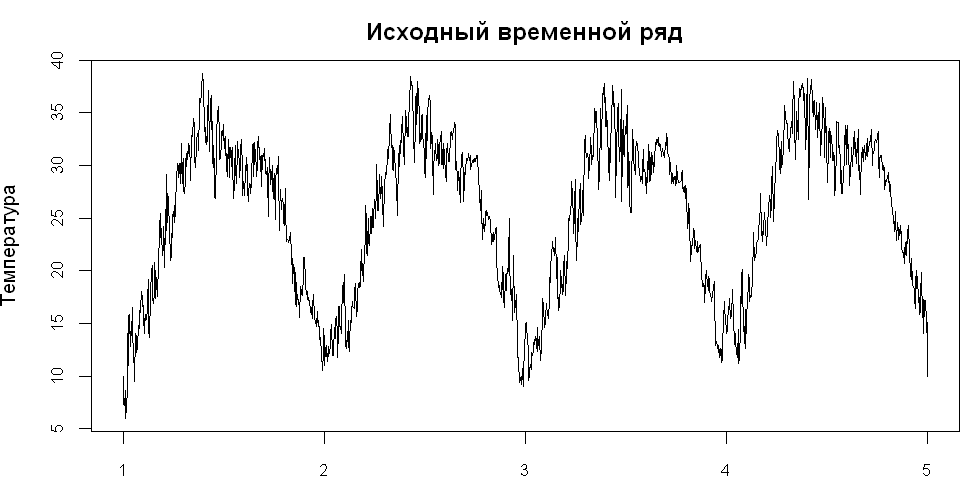

In [4]:
train <- read.csv("data/DailyDelhiClimateTrain.csv")

y_train = ts(train[, 2], freq=365.25)

plot_ts(y_train, title='Исходный временной ряд')

Хоть и не слишком так уверено, но отвергать гипотезу, что остатки несмещенны, нельзя, так как p-value критерия Стьюдента больше 0.05. А критерий Дики-Фуллера говорит о том, что ряд остатков стационарен, что и необходимо. Но что же такое q-критерий Льюнга-Бокса? А он говорит нам о том, что остатки не автокоррелированы. Это удобнее, чем каждый раз на коррелограмму смотреть.

Оценка остатков:
Критерий Стьюдента: p=0.1729
Критерий Дики-Фуллера: p=0.0100
Q-критерий Льюанга-Бокса: р=0.7554

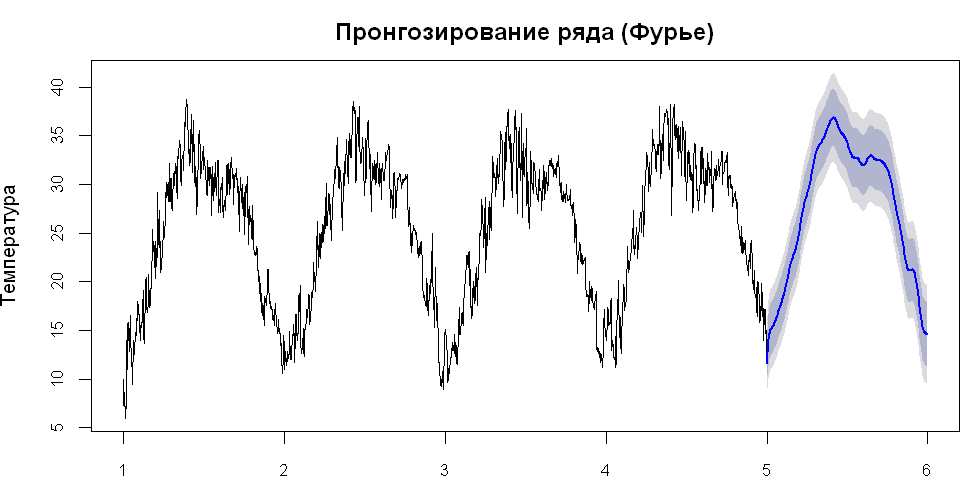

In [5]:
K = 15

fit <- auto.arima(y_train, seasonal=FALSE, xreg=fourier(y_train, K=K))

plot_ts(forecast(fit, h=365, xreg=fourier(y_train, K=K, h=365)), title='Пронгозирование ряда (Фурье)')

evaluate_resids(residuals(fit))

Один из плюсов __R__ - наличие стабильно работающей Auto ARIMA. Ну, и встроенного преобразование Фурье.  
В общем-то, мы перешли к __R__ только ради встроенного преобразования Фурье.

MSE = 7.451, RMSE = 2.730

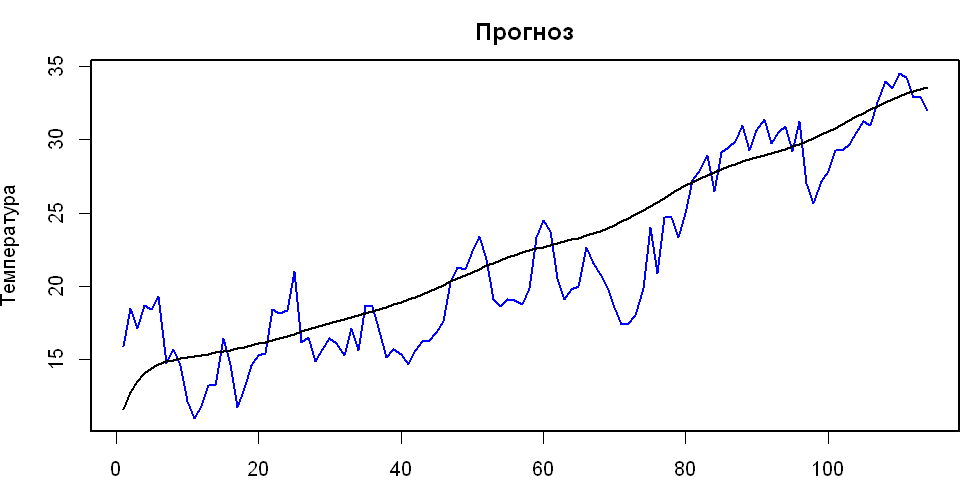

In [6]:
test <- read.csv("data/DailyDelhiClimateTest.csv")

y_test = test[, 2]
y_pred = c(predict(fit, n.ahead=length(y_test), newxreg=fourier(y_train, K=K, h=length(y_test)))$pred)

compare_test_pred(y_test, y_pred)

Что ж, $ RMSE = 2.730 $, что уже довольно-таки неплохо. Но ведь в нашем датасете есть еще и другие составляющие помимо температуры. Давайте используем их.

In [7]:
L_train = length(train[, 1])
y_train = ts(train[, 2][2:L_train], freq=365.25)

xreg <- cbind(
    shift(train[, 3], 1)[2:L_train],
    shift(train[, 4], 1)[2:L_train],
    shift(train[, 5], 1)[2:L_train],
    fourier(y_train, K=K)
)

Здесь я обрезаю первые значения, потому что при сдвиге на месте первого значения появляется _NaN_. А сам сдвиг нужен, чтобы на основании вчераших данных прогнозировались данные сегодняшние.

In [8]:
fit <- auto.arima(y_train, seasonal=FALSE, xreg=xreg)

evaluate_resids(residuals(fit))

Оценка остатков:
Критерий Стьюдента: p=0.1314
Критерий Дики-Фуллера: p=0.0100
Q-критерий Льюанга-Бокса: р=0.9320

Норм такие остатки, одобряю. Хотя, если брать $\alpha=0.15$, то, конечно, не очень такие остатки. Но кто в своем уме берет $\alpha=0.15$?

MSE = 7.097, RMSE = 2.664

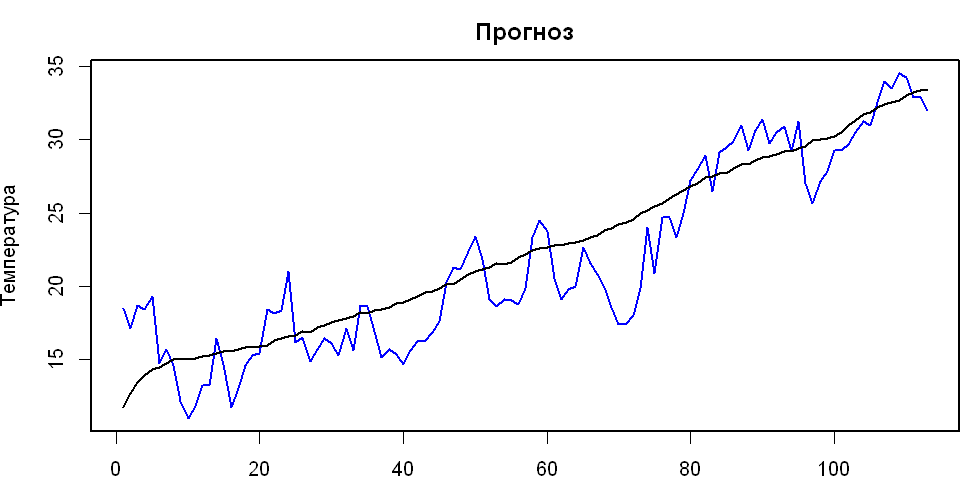

In [9]:
L_test = length(test[, 1])
y_test = ts(test[, 2][2:L_test], freq=365.25)

xreg <- cbind(
    shift(test[, 3], 1)[2:L_test],
    shift(test[, 4], 1)[2:L_test],
    shift(test[, 5], 1)[2:L_test],
    fourier(y_train, K=K, h=length(y_test))
)
y_pred = c(predict(fit, n.ahead=length(y_test), newxreg=xreg)$pred)

compare_test_pred(y_test, y_pred)

М-м-м... Люблю повышение качества. Давайте попробуем еще.

In [10]:
L_train = length(train[, 1])
y_train = ts(train[, 2][3:L_train], freq=365.25)

xreg <- cbind(
    shift(train[, 3], 1)[3:L_train],
    shift(train[, 4], 1)[3:L_train],
    shift(train[, 5], 1)[3:L_train],
    shift(train[, 3], 2)[3:L_train],
    shift(train[, 4], 2)[3:L_train],
    shift(train[, 5], 2)[3:L_train],
    fourier(y_train, K=K)
)
fit <- auto.arima(y_train, seasonal=FALSE, xreg=xreg)

evaluate_resids(residuals(fit))

Оценка остатков:
Критерий Стьюдента: p=0.1174
Критерий Дики-Фуллера: p=0.0100
Q-критерий Льюанга-Бокса: р=0.6438

Забавная картина, конечно, - чем выше количество дополнительных параметров, тем меньше критерий Стьюдента. Но это не так важно, главное, что его p-value > $\alpha$.

MSE = 6.582, RMSE = 2.565

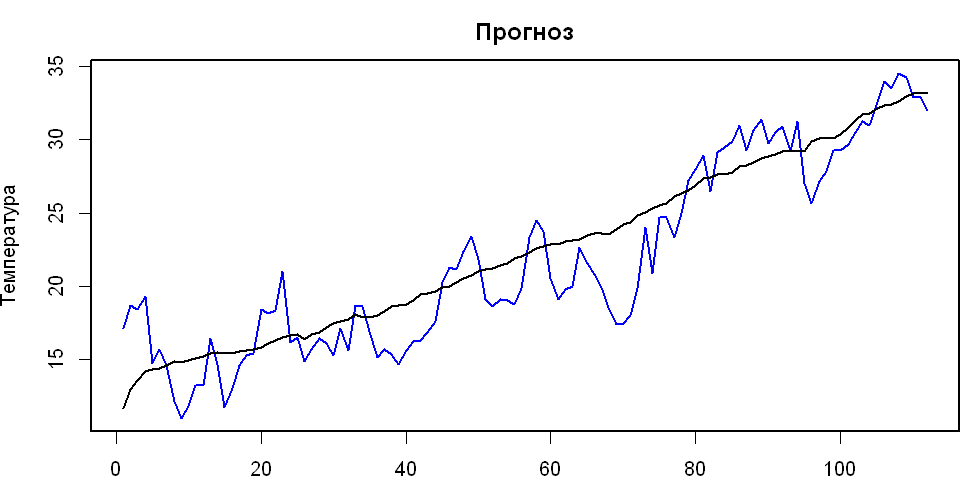

In [11]:
L_test = length(test[, 1])
y_test = ts(test[, 2][3:L_test], freq=365.25)

xreg <- cbind(
    shift(test[, 3], 1)[3:L_test],
    shift(test[, 4], 1)[3:L_test],
    shift(test[, 5], 1)[3:L_test],
    shift(test[, 3], 2)[3:L_test],
    shift(test[, 4], 2)[3:L_test],
    shift(test[, 5], 2)[3:L_test],
    fourier(y_train, K=K, h=length(y_test))
)
y_pred = c(predict(fit, n.ahead=length(y_test), newxreg=xreg)$pred)

compare_test_pred(y_test, y_pred)

Итого, _RMSE_ уменьшилось на  0.165. Звучит не очень сильно. С другой стороны, _MSE_ понизилось на 0.867.  
А это знаете ли!..  
В общем-то то же самое, но прикольнее звучит.

И-и-и все. Можно конечно еще поиграться с моделью, самому собрать свою ARIMA, больше использовать данных за предыдущие дни, но уже и так неплохо. 

Так что, как говорил классик: "Спасибо за просмотр! Я люблю вас! И до встр-р-речи в следующий раз!" \*Тум-ту-ту-ду-тум-тум\*.